In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PyQt5
import matplotlib.pyplot as plt
import datetime as dt
import tsai

c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [12]:
from tsai.all import *

ImportError: cannot import name 'sliding_window_view' from 'numpy.lib.stride_tricks' (c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\numpy\lib\stride_tricks.py)

In [ ]:
data = pd.read_csv("../complete_merged.csv",index_col=0)

In [ ]:
%%script false
window_len = 10
horizon = 1
x_vars = None
y_vars = None
X, y = apply_sliding_window(data, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, data))
print(np.shares_memory(y, data))
print(X.shape, y.shape)
# test_eq(X.shape, (len(df) - (window_len - 1 + horizon), df.shape[1], window_len))
# test_eq(y.shape, (len(df) - (window_len - 1 + horizon), df.shape[1]))
X[0], y[0]

Couldn't find program: 'false'


In [ ]:
#Testing datetime consecutiveness


def checkConsecutiveDates(date_strs):
    dates = [dt.datetime.strptime(d, "%Y-%m-%d") for d in date_strs]

    date_ints = set([d.toordinal() for d in dates])
    if len(date_ints) == 1:
        return True
    elif max(date_ints) - min(date_ints) == len(date_ints) - 1:
        return True
    else:
        return False
    


def split_sequence(date_sequence,temp_sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(temp_sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
 # check if we are beyond the sequence
        if end_ix > len(temp_sequence)-1:
            break
 # gather input and output parts of the pattern
        seq_x, seq_y = temp_sequence[i:end_ix], temp_sequence[end_ix]
        date_seq = date_sequence[i:end_ix]
        # print(checkConsecutive(seq_x))
        if(checkConsecutiveDates(date_seq)):
            X.append(seq_x)
            y.append(seq_y)
    X,y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
        
    return X,y

def get_data(district,column):
    return data[data['district'] == district].sort_values(axis = 0,by = "date")[column].to_list()
   



# date_strs = ['02-29-2012', '02-28-2012', '03-01-2012']
date_strs = ['1999-12-31','2000-01-01']
print(checkConsecutiveDates(date_strs))

X,y = split_sequence(['2021-01-09','2021-01-11','2021-01-12','2021-01-13','2021-01-14'],[10, 20, 30, 40, 50],3,1)
for i in range(len(X)):
    print(X[i], y[i])





True
[[20]
 [30]
 [40]] 50


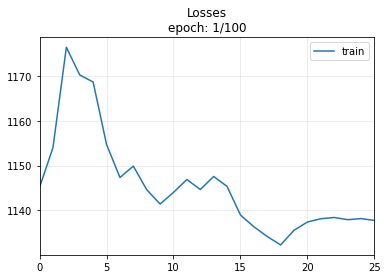

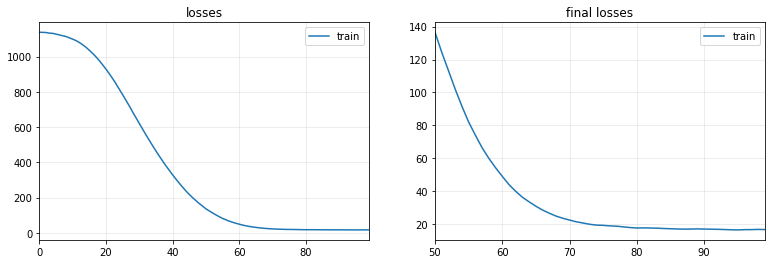

In [ ]:
data_Adilabad_temp = get_data('Adilabad','temp_max')
data_Adilabad_date = get_data('Adilabad','date')
# print(data_Adilabad_date)
X,y = split_sequence(data_Adilabad_date,data_Adilabad_temp,10,1)

batch_tfms = TSStandardize(by_sample=True)
reg = TSRegressor(X, y, path='models', arch=TSTPlus, batch_tfms=batch_tfms, metrics=rmse, cbs=ShowGraph(), verbose=True)
reg.fit_one_cycle(100, 3e-4)
reg.export("reg.pkl")

In [ ]:
from tsai.inference import load_learner
reg = load_learner("models/reg.pkl")
raw_preds, target, preds = reg.get_X_preds(X, y)

In [ ]:
print(raw_preds)
print(target)
print(preds)

TensorBase([[32.4862],
            [30.3764],
            [31.3879],
            ...,
            [31.6595],
            [32.6720],
            [29.9696]])
tensor([31.8421, 30.1000, 32.8842,  ..., 33.8944, 32.6056, 32.1667],
       dtype=torch.float64)
TensorBase([[32.4862],
            [30.3764],
            [31.3879],
            ...,
            [31.6595],
            [32.6720],
            [29.9696]])


In [ ]:
date_X,date_y = split_sequence(data_Adilabad_date,data_Adilabad_date,10,1)

%matplotlib qt
date_y = np.asarray(date_y, dtype='datetime64[s]')

plt.plot(date_y,target)
plt.plot(date_y,preds)
plt.show()